# Ibis: Python Data Analysis Productivity Framework

Ibis is a library pretty useful on data analysis tasks. That allows you work locally over a schema, like create filter, add columns, apply math operations etc and when you want to get the result of the expression you created, Ibis compiles that and makes a request to the remote server (remote storage and execution systems like Hadoop components or SQL databases). Its goal is to simplify analytical workflows and make you more productive.

Ibis was created by Wes McKinney (@wesm) and is mainly maintained by Phillip Cloud (@cpcloud) and Krisztián Szűcs (kszucs). Also, recently, I was invited as contributor to Ibis repository!

Maybe you are thinking: "why should I use Ibis?". Well, if you have any of these follow issues, probably you should consider use ibis in your analytical workflow!

- if you need to get data from a SQL Database but you don't know much about SQL ...
- if you create SQL statements manually using string and have a lot of `IF`'s in your code that compose specific parts of your SQL code (it could be pretty hard to maintain and it will makes your code pretty ugly) ...
- if you need to handle data with big volume ...

<!-- TEASER_END -->

If you want to learn more about ibis consider to take a look into these tutorials:

* https://docs.ibis-project.org/tutorial.html

Do you want to watch some interesting video about Ibis? Check this out:

* https://www.youtube.com/embed/8Tzh42mQjrw?start=1625

**Now, let's check out some work developed here at Quansight in the last months!**

During the last months OmniSci and Quansight were working together to add a backend on Ibis for OmniSciDB (former MapD) that also resulted on new expressions/operators on Ibis core, such as:

- GeoSpatial data types and operations
- Trigonometric operations
- Some statistcal operations

First, let's connect to a *OmniSciDB* and play with this new features!

In [1]:
# install the dependencies if you need!
# !conda install -y ibis-framework=1.1.0 pyarrow pymapd vega geopandas geoalchemy2 shapely matplotlib --force-reinstall

In [2]:
import ibis
from matplotlib import pyplot as plt

print('ibis:', ibis.__version__)

ibis: 1.1.0


In [3]:
omniscidb_cli = ibis.mapd.connect(
    host='metis.mapd.com', 
    user='mapd', 
    password='HyperInteractive',
    port=443, 
    database='mapd',
    protocol='https'
)

### GeoSpatial features

You need to handle geospatial data in a esier way?

Let's take a look inside `zipcodes_2017` table!

Well, currently `omniscidb` backend doesn't support `geopandas` output, so let's use a workaround for that! It should be implemented into `omniscidb` backend soon! (see: [gist-code](https://gist.githubusercontent.com/xmnlab/587dd1bde44850f3117a1087ed3f0f28/raw/0750400db90cf97319a91aa514648c31ad4ace45/omniscidb_geopandas_output.py))

In [4]:
gist_url = 'https://gist.githubusercontent.com/xmnlab/587dd1bde44850f3117a1087ed3f0f28/raw/0750400db90cf97319a91aa514648c31ad4ace45/omniscidb_geopandas_output.py'
!wget {gist_url} -O omniscidb_geopandas_output.py

--2019-06-24 17:27:08--  https://gist.githubusercontent.com/xmnlab/587dd1bde44850f3117a1087ed3f0f28/raw/0750400db90cf97319a91aa514648c31ad4ace45/omniscidb_geopandas_output.py
Resolviendo gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.4.133
Conectando con gist.githubusercontent.com (gist.githubusercontent.com)[151.101.4.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 1874 (1,8K) [text/plain]
Guardando como: “omniscidb_geopandas_output.py”

omniscidb_geopandas 100%[===================>]   1,83K  --.-KB/s    en 0s      

2019-06-24 17:27:08 (59,2 MB/s) - “omniscidb_geopandas_output.py” guardado [1874/1874]



In [5]:
# workaround to use geopandas output
from omniscidb_geopandas_output import enable_geopandas_output 
enable_geopandas_output(omniscidb_cli)

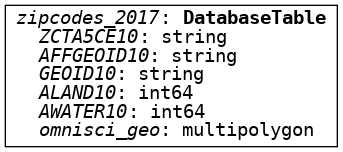

In [6]:
t = omniscidb_cli.table('zipcodes_2017')
display(t)

In [7]:
print('# rows:', t.count().execute())

# rows: 33144


This table has ~33k rows. For this example, let's use just the first 1k rows.

In [8]:
expr = t[t.omnisci_geo].head(1000)
df = expr.execute()

Instead of get all rows from the database and get from that the first 1k rows, Ibis will prepare a SQL to get just the first 1k rows! So it reduces the memory consuming to just the data you need!

This is what Ibis will request to the database:

In [9]:
print(expr.compile())

SELECT "omnisci_geo"
FROM zipcodes_2017
LIMIT 1000


Of course geospatial data reading as text wouldn't be useful, so let's plot the result!

**Remember: we are using geopandas here!**

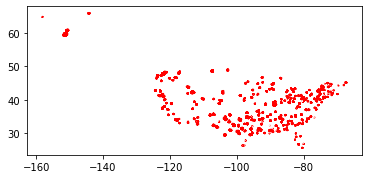

In [10]:
# let's add some custom style :)
style_kwds = {
    'linewidth': 2,
    'markersize': 2,
    'facecolor': 'red',
    'edgecolor': 'red'
}

df['omnisci_geo'].iloc[::3].plot(**style_kwds)
plt.show()

### Trigonometric operations

Currently OmniSciDB backend support the follow trigonometric operations: `acos`, `asin`, `atan`, `atan2`, `cos`, `cot`, `sin`, `tan`.

Let's check a example using a sin operation over `rowid` from `zipcodes_2017`.

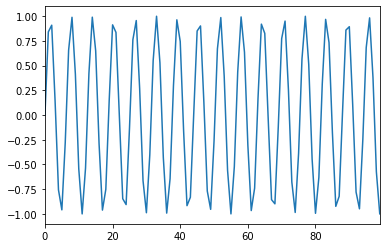

In [11]:
# if you want to use a SQL statement try`sql` method!
t = omniscidb_cli.sql('select rowid from zipcodes_2017')

expr = t[t.rowid, t.rowid.sin().name('rowid_sin')].sort_by('rowid').head(100)
expr.execute().rowid_sin.plot()
plt.show()

### Some statistical operations

OmniSciDB Ibis backend also implements some statistical operations, such as: `Correlation (corr)`, `Standard Deviation (stddev)`, `Variance (var)` and `Covariance (cov)`.

Let's check a pretty simple example if there is any correlation in this dataset between `per capita income` and `education`.

In [12]:
t = omniscidb_cli.table('demo_vote_clean')
# remove some conflictives fields: 'TYPE', 'NAME', 'COUNTY' field
fields = [name for name in t.schema().names if name not in ('TYPE', 'NAME', 'COUNTY')]
t = t[fields].distinct()
t.PerCapitaIncome.corr(t.Education).execute()

0.7212061029308422

The result `~0.72` means that `Per Capita Income` and `Education` has a positive correlation in this dataset.

### Conclusions

Ibis is a cool library that can help you in your data analysis workflow. 

If you already use pandas, it will be pretty easy to add Ibis in your workflow!

So ...

* Are you excited to use Ibis? [Try it out now](https://docs.ibis-project.org/getting-started.html)!
* Have you already used Ibis? [Please share with us your feedback!](https://twitter.com/messages/compose?recipient_id=945906846715580416)
* Are you interested in to contribute with Ibis? Check [good first issues](https://github.com/ibis-project/ibis/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22) label on GitHub!
* Do you want to add new features and want to fund Ibis? [Contact us!](https://twitter.com/messages/compose?recipient_id=945906846715580416) :)